In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
! pip install plotly==5.13.0

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621

[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: python3.9 -m pip install --upgrade pip


In [3]:

!pip install chart-studio

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621

[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: python3.9 -m pip install --upgrade pip


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from chart_studio import plotly as py
import plotly.graph_objs as pgo
import glob
import seaborn as sns

In [5]:
measure = pd.read_csv("measurement.csv", decimal=',', low_memory=False)
specimen = pd.read_csv("specimen.csv", decimal=',', low_memory=False)

In [6]:
all_data = measure.merge(specimen, on="specimen_no", how="inner")

# Paleobiology dataset
Source: https://paleobiodb.org/#/

For my dataset, I chose to download the specimen and measurements of occurrences found in Europe. I am going to look into the distribution of the measurements of fossil occurences, and see how they can be grouped by similarities.

The below table shows my data as I received it. Immediately you can see NaNs and missing data. 

In [7]:
all_data.head()

,measurement_no,specimen_no,record_type_x,n_measured_x,position,measurement_type,average,min,max,record_type_y,...,identified_name,identified_rank,identified_no,difference,accepted_name,accepted_rank,accepted_no,max_ma,min_ma,reference_no
0,151,76,mea,33.0,NaN,length,29.42,NaN,NaN,spm,...,Alces alces,species,43850,NaN,Alces alces,species,45013.0,0.126,0.0117,8850
1,152,76,mea,33.0,NaN,width,20.48,NaN,NaN,spm,...,Alces alces,species,43850,NaN,Alces alces,species,45013.0,0.126,0.0117,8850
2,22020,10998,mea,1.0,NaN,diagonal,49.49,NaN,NaN,spm,...,Orthodesma,genus,16394,NaN,Orthodesma,genus,16394.0,457.5,455.8,6157
3,22021,10998,mea,1.0,NaN,length,65.54,NaN,NaN,spm,...,Orthodesma,genus,16394,NaN,Orthodesma,genus,16394.0,457.5,455.8,6157
4,22022,10998,mea,1.0,NaN,height,24.9,NaN,NaN,spm,...,Orthodesma,genus,16394,NaN,Orthodesma,genus,16394.0,457.5,455.8,6157


#### First of all, lets look at some basic info. I want to check the shape of my data and what is missing.

In [8]:
# Checking out shape and info on missing values

all_data.shape


(87381, 34)

In [9]:
pd.options.display.max_rows = 4000

87,381 rows and 34 columns. Now I want to check how many columns have missing data:

In [10]:
# 87,381 rows and 34 columns

missing_values_count = all_data.isnull().sum()
missing_values_count

measurement_no            0
specimen_no               0
record_type_x             0
n_measured_x              5
position              84788
measurement_type          0
average                   0
min                   87381
max                   87381
record_type_y             0
flags                 87285
occurrence_no             0
reid_no                   0
collection_no             0
specimen_id           13180
is_type               57229
specelt_no            87381
specimen_side         79761
specimen_part          3776
specimen_sex          82969
n_measured_y              5
measurement_source     4767
magnification         82471
comments              84131
identified_name           0
identified_rank           5
identified_no             0
difference            70683
accepted_name            22
accepted_rank            22
accepted_no              22
max_ma                    0
min_ma                    0
reference_no              0
dtype: int64

In [11]:
data = all_data

In [12]:
data = data.drop(['position', 'min', 'max', 'flags', 'specimen_id', 'is_type', 'is_type', 'specelt_no', 'specimen_side', 'specimen_part', 'specimen_sex', 'measurement_source', 'magnification', 'comments', 'difference', 'reid_no', 'record_type_x'], axis=1)

I can see from this result that <b>min</b> and <b>max</b> are fully missing, position has most missing, as well as specimen_id, is_type, specelt_no etc. I think for the columns with so much missing data, I'm going to drop them. 
But first I'm going to make a copy of my dataset incase I get this all wrong.

I can also check the types of columns I have remaining:

In [13]:
data.dtypes

measurement_no        int64
specimen_no           int64
n_measured_x        float64
measurement_type     object
average              object
record_type_y        object
occurrence_no         int64
collection_no         int64
n_measured_y        float64
identified_name      object
identified_rank      object
identified_no         int64
accepted_name        object
accepted_rank        object
accepted_no         float64
max_ma               object
min_ma               object
reference_no          int64
dtype: object

#### I have a lot of dtype = object, which I don't want, so I'm going to convert them. I make sure any commas in my "average" column are changed to decimal points, and then I convert the column to float. 

In [14]:
data["average"] = data["average"].str.replace(',','.')

In [15]:
data["average"] = data["average"].astype(float)

Since I'm focusing on looking at smallest and largest occurences, I also decide to reduce my dataset a little bit more and zoom into my current focus, so below I have sliced it to show the name, measurement type and the measurements after.

In [16]:
avg_measurement_by_spec = data.groupby(["accepted_name", "measurement_type"])["average"].agg([min, max, np.mean])
avg_measurement_by_spec.head()


min   max       mean
accepted_name              measurement_type                       
Aalenirhynchia subdecorata height            20.1  22.1  21.200000
                           length            19.5  21.5  20.433333
                           width             24.4  27.5  26.133333
Aalenirhynchia walkeri     height            18.9  18.9  18.900000
                           length            22.5  22.5  22.500000

# My focus in this project is the distribution of the measurements of some of the fossil occurrences recorded. 

In [17]:
measured_data = pd.DataFrame(avg_measurement_by_spec)

In [18]:
measured_data = measured_data.reset_index(level="measurement_type")

In [19]:
pivot = measured_data.pivot_table(values="mean", index="accepted_name", columns="measurement_type", fill_value=0)

#### Below is my table I'm working with. I have all of the measurements of the fossils. Lets look at the longest and shortest ones!

In [20]:
pivot

measurement_type,circumference,diagonal,diameter,height,inflation,length,width
accepted_name,,,,,,,
Aalenirhynchia subdecorata,0.0,0.0,0.0,21.2,0.0,20.433333,26.133333
Aalenirhynchia walkeri,0.0,0.0,0.0,18.9,0.0,22.500000,26.300000
Abaptilon sibiricum,0.0,0.0,0.0,0.0,0.0,40.000000,16.500000
Abashevia suchovi,0.0,0.0,0.0,0.0,0.0,27.000000,10.500000
Abbasitoides modestus,0.0,0.0,39.0,13.0,17.5,0.000000,13.000000
...,...,...,...,...,...,...,...
Zygopleura walmstedti,0.0,0.0,0.0,19.4,0.0,0.000000,8.066667
Zygoptera,0.0,0.0,0.0,0.0,0.0,62.500000,0.000000
Zygospira,0.0,0.0,0.0,0.0,0.0,21.490000,24.390000


In [21]:
pivot.sort_values(by = 'length', ascending=False)

measurement_type,circumference,diagonal,diameter,height,inflation,length,width
accepted_name,,,,,,,
Balaenoptera (Plesiocetus) cortesii,0.0,0.0,0.000000,0.0000,0.000000,1980.0,750.000000
Lusotitan atalaiensis,1100.0,0.0,0.000000,0.0000,0.000000,1525.0,0.000000
Zygophyseter varolai,0.0,0.0,0.000000,0.0000,0.000000,1480.0,745.000000
Titanocetus sammarinensis,0.0,0.0,0.000000,0.0000,0.000000,1330.0,720.000000
Aragosaurus ischiaticus,0.0,0.0,0.000000,0.0000,0.000000,1310.0,332.500000
...,...,...,...,...,...,...,...
Asteroceras reynesi,0.0,0.0,45.350000,0.0000,0.000000,0.0,16.335000
Praewerneroceras suchomastense,0.0,0.0,30.687500,13.8125,7.812500,0.0,16.875000
Praesibirites tuberculatus,0.0,0.0,39.733333,10.9000,19.933333,0.0,8.566667


In [22]:
pivot.sort_values(by = 'width', ascending=False)

measurement_type,circumference,diagonal,diameter,height,inflation,length,width
accepted_name,,,,,,,
Balaenoptera (Plesiocetus) cortesii,0.0,0.0,0.0,0.0,0.0,1980.000,750.0
Zygophyseter varolai,0.0,0.0,0.0,0.0,0.0,1480.000,745.0
Uranocetus gramensis,0.0,0.0,0.0,0.0,0.0,606.750,736.0
Titanocetus sammarinensis,0.0,0.0,0.0,0.0,0.0,1330.000,720.0
Pinocetus polonicus,0.0,0.0,0.0,0.0,0.0,897.500,706.0
...,...,...,...,...,...,...,...
Psiloptera incerta,0.0,0.0,0.0,0.0,0.0,13.000,0.0
Mordellistena soror,0.0,0.0,0.0,0.0,0.0,3.400,0.0
Cinetus elongatus,0.0,0.0,0.0,0.0,0.0,4.175,0.0


### The longest and widest fossil record is the 'Balaenoptera cortesi'...

The Plesiocetus were a genus of extinct balaenopterids. These were a type of whale. Some of the extant (current) species within this genus are the Minke's whale, fin whale, blue whale and Omura's whale. 

They would have looked similar to this: 

![balaenoptera_whale](balae_whale.jpeg)

###### image source: [wikiwand](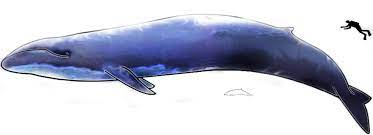)

### Now lets look at the tallest fossil record.. the Pachydesmoceras pachydiscoide

In [23]:
pivot.sort_values(by = 'height', ascending=False)

measurement_type,circumference,diagonal,diameter,height,inflation,length,width
accepted_name,,,,,,,
Pachydesmoceras pachydiscoide,0.0,0.0,1080.00,420.500000,322.5,0.00,293.50
Parapuzosia (Parapuzosia) seppenradensis,0.0,0.0,1280.25,370.166667,396.0,0.00,476.00
Pustulifer alpina,0.0,0.0,0.00,300.000000,0.0,0.00,102.00
Pinacoceras parma,0.0,0.0,512.50,282.500000,47.5,0.00,66.00
Pinacoceras metternichi,0.0,0.0,495.00,275.000000,43.0,0.00,71.00
...,...,...,...,...,...,...,...
Mastotermes nepropadyom,0.0,0.0,0.00,0.000000,0.0,10.00,0.00
Mastotermes picardi,0.0,0.0,0.00,0.000000,0.0,19.65,8.50
Mastotermes sarthensis,0.0,0.0,0.00,0.000000,0.0,7.00,0.00


These are a genus of ammonites. They were actually carnivorous, and lived during the cretaceous period. Here is a fossil from a museum in Japan: 

![pachydemoceras](Pachydesmoceras_pachydiscoide.jpg)

###### image source: [wikipedia](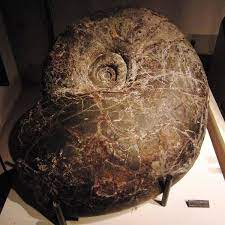)

 They don't look too scary like this, but if you saw one swimming... 

 ![pachydesmoceras](ammonite-swimming.jpg)

 ###### image source [pachydesmoceras](https://www.google.co.uk/url?sa=i&url=https%3A%2F%2Fammonite360.wordpress.com%2F2016%2F03%2F27%2Flocomotion%2F&psig=AOvVaw2gxWLo1iz0mTldOsYdenqM&ust=1676659316415000&source=images&cd=vfe&ved=0CA8QjRxqFwoTCJirv-nYmv0CFQAAAAAdAAAAABAK)

Next up, let's look at the smaller fossils...

#### The Pseudococcites eocaenicus... an extinct version of what we would call a 'mealybug'. 

They are in the scale insect family - I found one paper which suggested that this particular species are unique to Kachin amber. 

###### Source: [Kachin amber](https://www.nature.com/articles/s41598-020-68220-x)

![bug](bug.jpeg)

### So next I'm interested in seeing if my dataset can be fit into clusters.

Since my dataset is quite large, I'm going to use a logarithmic scale to visualise it in a more compact way.

In [25]:

import plotly.express as px
fig = px.scatter(pivot, x="width", y="length", title="Length and width of fossil occurrences", log_x=True, log_y = True)
fig.show()

From this, we can see that there is a positive correlation between the width and length of fossils. Although, we can see a few outliers on the lower and higher ends. 

#### Now for KMeans clustering

In [36]:
from sklearn.cluster import KMeans
pivot = pivot.drop('accepted_name', axis=1)



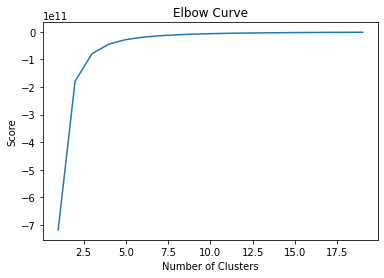

In [55]:
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
score = [kmeans[i].fit(pivot).score(pivot) for i in range(len(kmeans))]
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

From this I would say the optimal amount of clusters is around 3

In [65]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(pivot)
pivot['cluster'] = kmeans.fit_predict(pivot[['length', 'width', 'circumference', 'height', 'diagonal', 'diameter', 'inflation']])

Text(0, 0.5, 'Width')

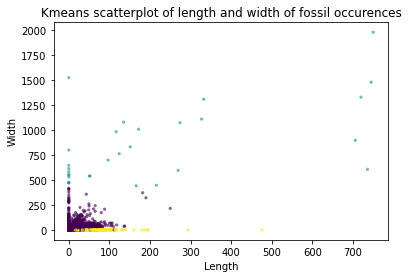

In [66]:
plt.scatter(pivot.width, pivot.length, c=pivot.cluster, alpha = 0.50, s = 5)
plt.title("Kmeans scatterplot of length and width of fossil occurences")
plt.xlabel('Length')
plt.ylabel('Width')

# Future work

I think it would be helpful to look at more than 2 components at a time, and to do this I would have to do PCA 2 components. 